# Automatic differentiation variational inference (ADVI)

In this lesson, we build up a conceptual understanding of how the function fitting algorithm in PyMC works. We focus on the differences between independent (called mean-field) and correlated (called full-rank) fits to the posterior distribution. A complete mathematical understanding of ADVI is beyond the scope of this course but we will cover the basics and references to the full treatment are provided for those who are interested to understand the algorithm more deeply.

**Run all cells** before you start reading below.

## Prep plan

* There are no required readings or videos. Spend all your prep time on this workbook and aim to complete all the exercises.
* (There are optional readings/videos at the end if you want to understand the ADVI algorithm in even more depth.)

## Review: Fitting a Normal

In the previous lesson, we saw that we can fit a Normal PDF to a 1-dimensional unnormalized posterior by finding the mode (peak) of the target distribution and then matching the variance of the Normal to the variance of the target at the mode.

In higher dimensions, we follow the same basic process to fit a Multivariate Normal distribution to the target by finding the mode of the target in its high-dimensional parameter space and then matching the covariance of the Multivariate Normal to the covariance of the target at the mode.

This algorithm is sometimes called the _Laplace approximation_ (named after the French mathematician who developed the foundations of what we now call Bayesian inference). The algorithm is _not_ what is used in PyMC but it is much simpler to compute and is a good way of introducing many of the concepts important for understanding the PyMC algorithm.

## Laplace approximation

Below we use the Laplace approximation to fit a Multivariate Normal distribution to a linear regression model we have seen before. The data set has an outlier and we fit a model with a Student T likelihood function to the data.

To fit a Normal approximation to a model, we follow these steps.

1. Transform the parameters so they are all unconstrained. The Normal distribution is defined for all real values and so we want all our parameters to be defined on the whole real line.
2. Find the peak (maximum) of the unnormalized log posterior distribution. We generally work with the log of the distribution since it is much better behaved numerically and since the peak of the log of a function is at the same location as the peak of the function itself.
3. Compute all second-order derivatives of the log posterior distribution at the peak. We use these derivatives to determine the covariance matrix for the Normal distribution.

### Load and standardize the data

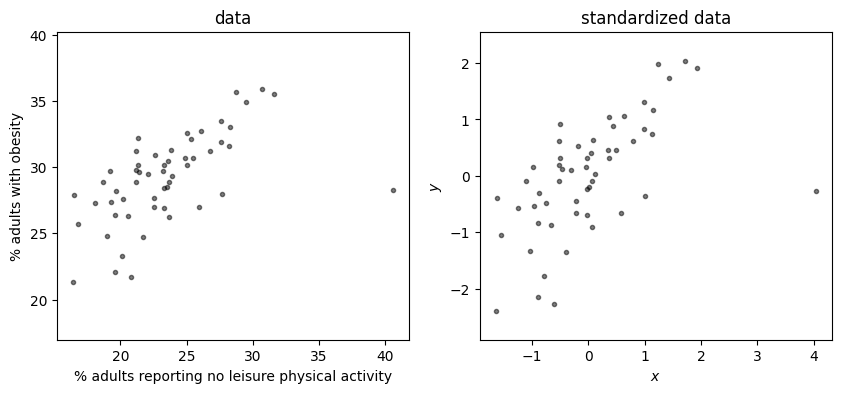

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as sts


df = pd.read_csv(
    'https://course-resources.minerva.edu/uploaded_files/mu/00265107-3137/obesity.csv')

# The complete data set. We sort the data by x-coordinate to make the plots look
# better so we know datum number 3, for example, is the 3rd point from the left.
# This has no impact on the inference results.
data_x = sts.zscore(df['no_activity_perc'])
data_y = sts.zscore(df['obesity_perc'])

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('data')
plt.xlabel('% adults reporting no leisure physical activity')
plt.ylabel('% adults with obesity')
plt.plot(df['no_activity_perc'], df['obesity_perc'], 'k.', alpha=0.5)
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.title('standardized data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(data_x, data_y, 'k.', alpha=0.5)
plt.axis('equal')

plt.show()

Next, we set up the model (using the standardized data) in PyMC. **Note:** We will **not** use PyMC to fit a Normal to this model. We will do it ourselves.

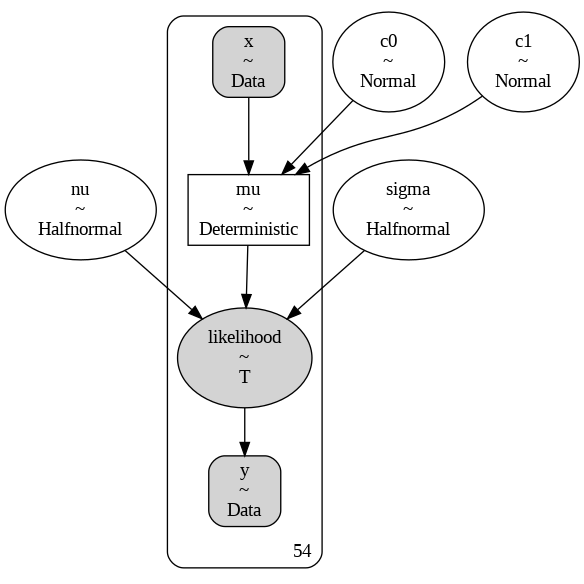

In [2]:
with pm.Model() as model:
    # Prior
    c0 = pm.Normal('c0', mu=0, sigma=1)
    c1 = pm.Normal('c1', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    nu = pm.HalfNormal('nu', sigma=30)
    # Data
    x = pm.Data('x', data_x)
    y = pm.Data('y', data_y)
    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x)
    # Likelihood
    pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma, observed=y)

from IPython.display import Image
Image(pm.model_to_graphviz(model).render(format='png'))

### Step 1: Transform the variables

PyMC has done this already! PyMC uses its built-in transformations to convert constrained parameters to unconstrained ones. In this model, we have two constrained parameters, $\sigma > 0$ and $\nu > 0$. When we look at the variables of the PyMC model, we see that they were log-transformed. The $c_0$ and $c_1$ parameters were not transformed since they are already unconstrained.

For both function fitting and MCMC sampling, we work in an unconstrained parameter space.

In [3]:
var_names = [x.name for x in model.value_vars]
print(var_names)

['c0', 'c1', 'sigma_log__', 'nu_log__']


### Step 2: Find the optimum

We use PyMC to construct the log posterior and its derivative. We use the `minimize` function in SciPy to find the peak of the log posterior.

In [4]:
from scipy.optimize import minimize

logp = model.compile_logp()  # log posterior (unnormalized)
dlogp = model.compile_dlogp()  # derivative of the unnormalized log posterior

# The two functions below map from a NumPy array with 4 values
# to the 4 unconstrained variables of the model. These functions
# also invert the sign of the function so we can use `minimize`
# to find the maximum of the log posterior.

def f(x):
    # The function to minimize
    return -logp(dict(zip(var_names, x)))

def df(x):
    # Derivative of the function to minimize
    return -dlogp(dict(zip(var_names, x)))

# Run the `minimize` function. This is a numerical optimization
# algorithm that uses the function values and the derivative of
# the function to move from a starting point (we just use zeros)
# to a minimum. We are not guaranteed that this is a global
# minimum so if the log posterior has multiple peaks, we will end
# up in one of them but without knowing about the others.

result = minimize(f, np.zeros(4), jac=df)
x_opt = {name: result.x[i] for i, name in enumerate(var_names)}  # x-coordinate of optimum
f_opt = -result.fun  # function value at optimum

print('x-coordinate at peak:            ', result.x)
print('derivative at peak (should be 0):', result.jac)
print('log posterior value at peak:     ', -result.fun)

x-coordinate at peak:             [ 0.118977    0.77791156 -0.46411536  1.70172278]
derivative at peak (should be 0): [-9.10595952e-07 -2.78299800e-06  3.04939679e-06 -4.45124186e-07]
log posterior value at peak:      -67.56104111952239


### Visualize contours around the optimum

Below we visualize the contours of the log posterior around the peak for all pairs of vars. You should see that the contours are centered there.

In [5]:
# You don't have to read through this function. Its purpose is to produce
# a contour plot of a 2-dimensional slice through a high-dimensional
# distribution. This function handles the messy details needed to produce
# the various contour plots in this workbok.

def plot_two_parameter_log_posterior_contour(model, variable_params, fixed_params=None, contour_kwargs=None):
    '''
    Inputs:

        model (pymc.Model) The model for which to produce a contour plot.

        variable_params (list of [str, array]) The two variables for which
          to produce the contour plot. These must be two variables listed
          in `model.value_vars`. Variable names can contain indices, for example
          "theta[1]" will plot the second entry in the theta parameter array.
          Provide the string name and a NumPy array of values for each variable.

        fixed_params (dict) This dictionary maps from each of the remaining
          variables in the model (not in `variable_params`) to fixed values.
          The contour plot will keep the values of these variables fixed and
          vary the values of the variables in `variable_params`. The dict maps
          from variable names to their values. Array variables must map to
          an array of values of the correct length. Scalar variables must map
          to scalar values.

        contour_kwargs (dict) Keyword arguments to pass on to the contour
          plotting function.
    '''

    # Check if any of the variable parameters contain indexes and parse them
    var_names = []
    var_indexes = []
    var_ranges = []
    for var_name, var_range in variable_params:
        if var_name.endswith(']'):
            pos = var_name.find('[')
            assert pos != -1
            var_index = int(var_name[pos+1:-1])
            var_name = var_name[:pos]
        else:
            var_index = None
        var_names.append(var_name)
        var_indexes.append(var_index)
        var_ranges.append(var_range)

    # Set up the log posterior density function and array of values for the
    # contour plot.
    logp = model.compile_logp()
    log_prob_values = np.empty((len(var_ranges[1]), len(var_ranges[0])))
    point = dict(fixed_params or {})
    for i, var1_value in enumerate(var_ranges[0]):
        if var_indexes[0] is not None:
            point[var_names[0]][var_indexes[0]] = var1_value
        else:
            point[var_names[0]] = var1_value
        for j, var2_value in enumerate(var_ranges[1]):
            if var_indexes[1] is not None:
                point[var_names[1]][var_indexes[1]] = var2_value
            else:
                point[var_names[1]] = var2_value
            log_prob_values[j, i] = logp(point)

    # Make the contour plot
    plt.contour(var_ranges[0], var_ranges[1], log_prob_values, **(contour_kwargs or {}))

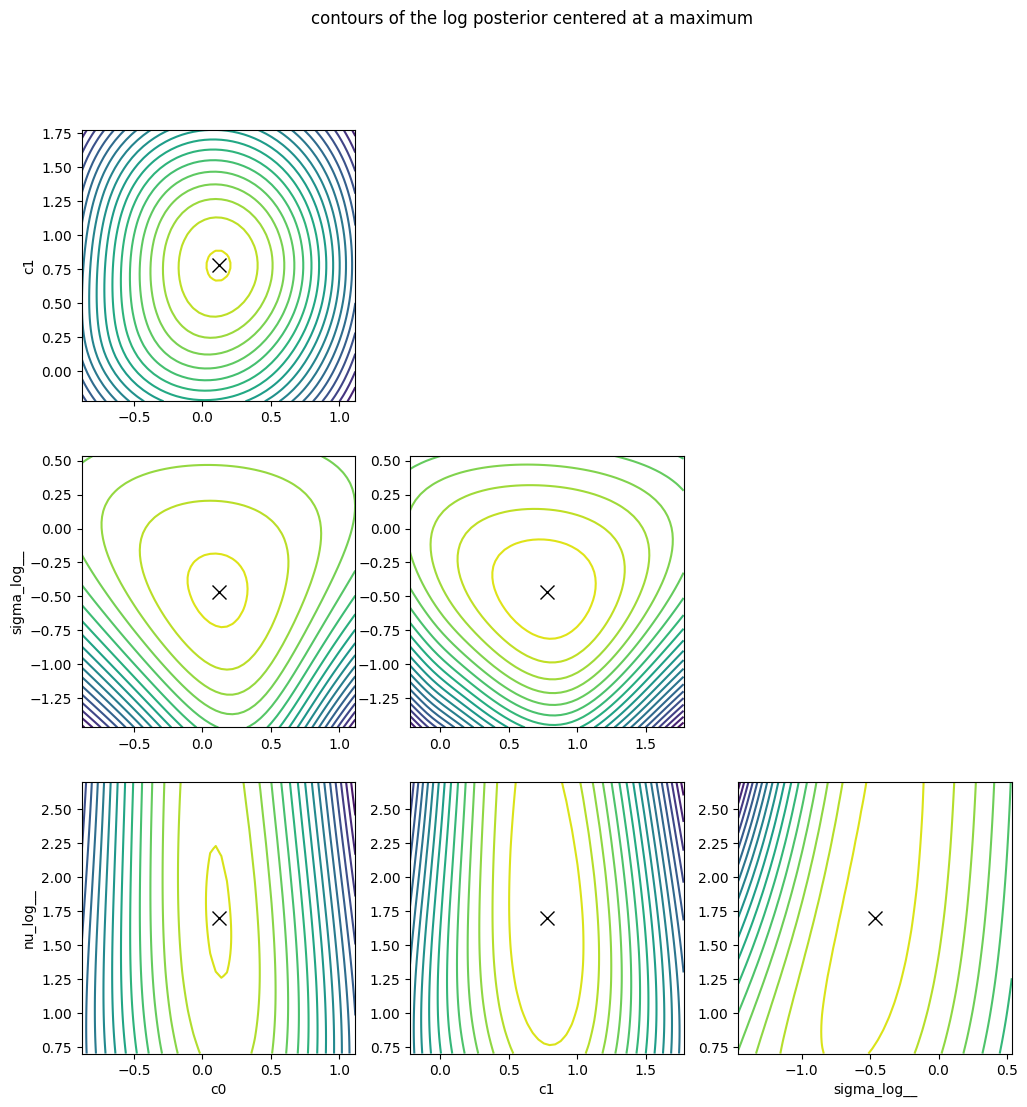

In [6]:
plt.figure(figsize=(12, 12))
plt.suptitle('contours of the log posterior centered at a maximum')
for i in range(len(var_names)-1):
    for j in range(i + 1):
        plt.subplot(len(var_names)-1, len(var_names)-1, i * (len(var_names)-1) + j + 1)
        var_x = var_names[j]
        var_y = var_names[i + 1]
        plot_two_parameter_log_posterior_contour(
            model,
            (
                (var_x, np.linspace(x_opt[var_x] - 1, x_opt[var_x] + 1)),
                (var_y, np.linspace(x_opt[var_y] - 1, x_opt[var_y] + 1))),
            x_opt,
            contour_kwargs={'levels': 20})
        plt.plot([x_opt[var_x]], [x_opt[var_y]], 'kx', markersize=10)
        if j == 0:
            plt.ylabel(var_y)
        if i == len(var_names) - 2:
            plt.xlabel(var_x)
plt.show()

What do you observe? Do you think a Multivariate Normal approximation to this log posterior centered at the peak will be a good approximation?

In [7]:
# ENTER YOUR ANSWER IN FORUM

### Step 3: Match the covariance

The way this works is that we set the collection of second-order derivatives of the log of the Normal PDF equal to the collection of second-order derivatives of the log posterior density. To see why this makes sense, look at what happens when we compute the second-order derivatives.

In the Multivariate Normal PDF, $\vec{x}$ and $\vec{\mu}$ are column vectors of length $k$ and $\Sigma$ is a $k\times k$ symmetric matrix.

$$\text{Normal}(\vec{x}\mid\vec{\mu},\Sigma) = \frac{1}{\sqrt{(2\pi)^k|\Sigma|}} \exp\left( -\frac{1}{2}(\vec{x}-\vec{\mu})^T \Sigma^{-1} (\vec{x}-\vec{\mu})\right)$$

Hence the log of the PDF is

$$\log\left(\text{Normal}(\vec{x}\mid\vec{\mu},\Sigma)\right) = -\frac{1}{2} \log\left((2\pi)^k|\Sigma|\right) -\frac{1}{2}(\vec{x}-\vec{\mu})^T \Sigma^{-1} (\vec{x}-\vec{\mu})$$
$$= \text{constant} - \frac{1}{2}\vec{x}^T \Sigma^{-1} \vec{x} + \vec{x}^T\Sigma^{-1}\vec{\mu}$$

To make things simpler, define $T = \Sigma^{-1}$. This inverse of the covariance matrix is usually called the _precision matrix_ of a Multivariate Normal distribution.

$$= \text{constant} - \frac{1}{2}\vec{x}^T T \vec{x} + \vec{x}^TT\vec{\mu}$$

When we take second order derivatives w.r.t. $\vec{x}$, the constant term falls away and the term $\vec{x}^TT\vec{\mu}$ also falls away since it is linear in $\vec{x}$. When we take the first derivative, a linear term becomes constant and when we take the second derivative, that constant becomes 0.

Hence

$$\frac{\partial^2}{\partial x_i\partial x_j} \log\left(\text{Normal}(\vec{x}\mid\vec{\mu},\Sigma)\right) = \frac{\partial^2}{\partial x_i\partial x_j}\ \frac{-1}{2}\vec{x}^T T \vec{x} = -T_{ij}$$

So, the collection of second-order derivatives of the log of a Multivariate Normal PDF equals the negative precision matrix (or, equivalently, the negative inverse covariance matrix, $-\Sigma^{-1}$).

We use this property of the Multivariate Normal to complete the approximation. We set the mean/mode of the Normal approximation to be at the mode of the target function. Then, we set the precision matrix of the Normal so the second-order derivatives of the approximation match the second-order derivatives of the target function at the mode.

This is known as a _full-rank_ approximation since we use the entire covariance or precision matrix to make the approximation. This matrix has $O(k^2)$ free variables which means it can be slow to do this when $k$ is very large. We will see below that we can get a worse but faster approximation by using the diagonal of this matrix rather than the full matrix.

In [8]:
# Note: There was a sign error in the d2logp function in PyMC. It computed the
# _negative_ second order derivatives for some reason. This behavior is currently
# being corrected, which is why the `negate_output=False` argument is needed
# below. They are busy changing the old, incorrect default behavior to new,
# correct default behavior. https://github.com/pymc-devs/pymc/issues/6310

# The precision matrix is -d2logp(x_opt).
d2logp = model.compile_d2logp(negate_output=False)
precision = -d2logp(x_opt)

# Create the full-rank Multivariate Normal model
with pm.Model() as approx_full_rank:

    # The Multivariate Normal approximation
    x = pm.MvNormal('x', mu=result.x, tau=precision)

    # Map from the x vector to the parameters of the original model.
    c_0 = pm.Deterministic('c0', x[0])
    c_1 = pm.Deterministic('c1', x[1])
    sigma = pm.Deterministic('sigma', pm.math.exp(x[2]))
    nu = pm.Deterministic('nu', pm.math.exp(x[3]))

### Visualize the approximation

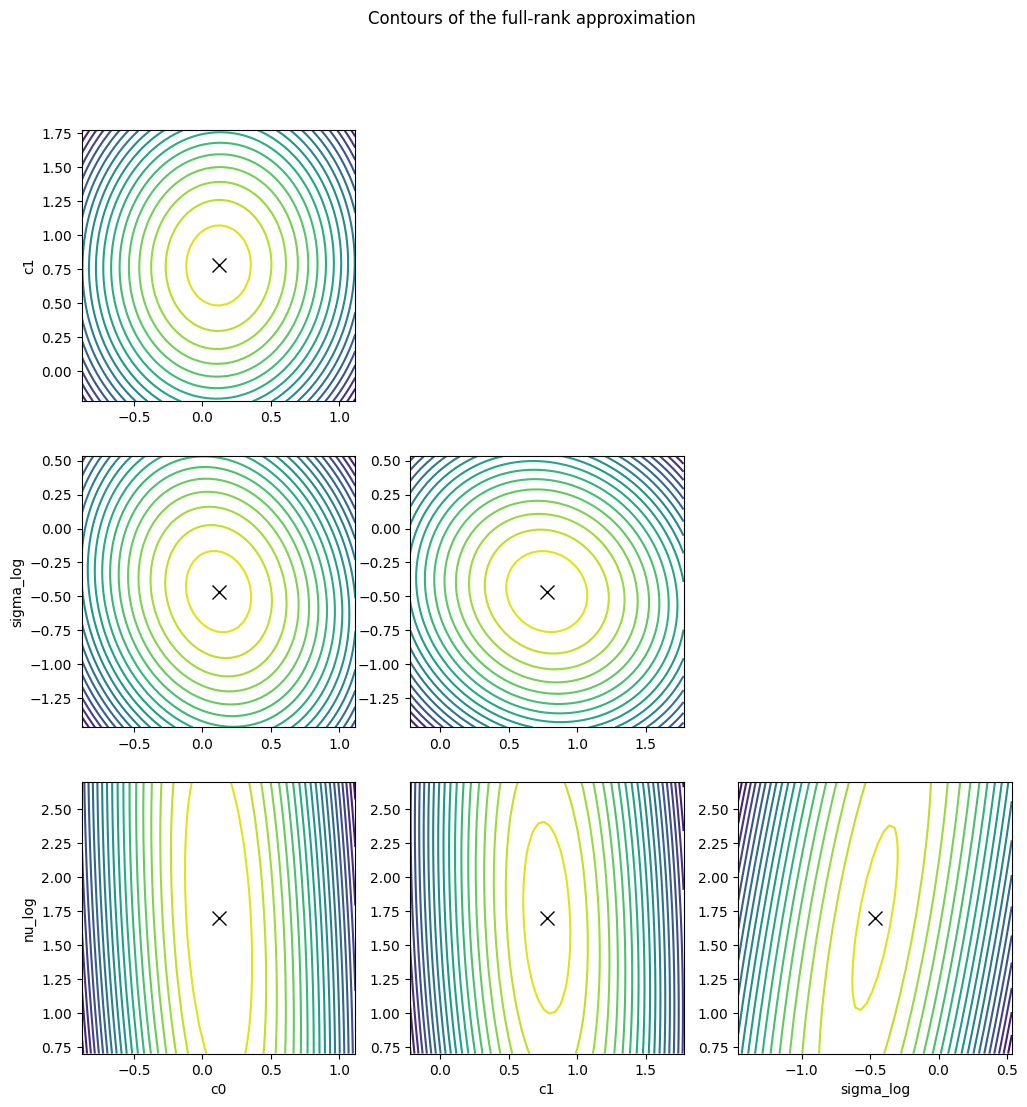

In [9]:
plt.figure(figsize=(12, 12))
plt.suptitle('Contours of the full-rank approximation')
for i in range(len(var_names)-1):
    for j in range(i + 1):
        plt.subplot(len(var_names)-1, len(var_names)-1, i * (len(var_names)-1) + j + 1)
        var_x = var_names[j]
        var_y = var_names[i + 1]
        plot_two_parameter_log_posterior_contour(
            approx_full_rank,
            (
                (f'x[{j}]', np.linspace(x_opt[var_x] - 1, x_opt[var_x] + 1)),
                (f'x[{i+1}]', np.linspace(x_opt[var_y] - 1, x_opt[var_y] + 1))),
            {'x': np.array([x_opt[var_names[k]] for k in range(len(x_opt))])},
            contour_kwargs={'levels': 20})
        plt.plot([x_opt[var_x]], [x_opt[var_y]], 'kx', markersize=10)
        if j == 0:
            plt.ylabel(var_y.rstrip('_'))
        if i == len(var_names) - 2:
            plt.xlabel(var_x.rstrip('_'))
plt.show()

Compare these contour plots to those of the original model. Write a short paragraph explaining what you think is good and what is bad about the approximation.

In [10]:
# ENTER YOUR ANSWER IN FORUM

### Mean-field and full-rank approximations

In a situation where we have very many parameters, computing all the second-order derivatives is too much work. For example, in a neural network with 1,000,000 weights, there would be approximately $\frac{1}{2}\times 10^{11}$ second-order derivatives to compute. A simpler approximation is to discard all the correlations between pairs of variables and model only the variances of the individual parameters.

This still gets some parts of the approximation right — we still fit the mode, and we estimate the length scale (standard deviation) of each parameter — but we lose all information about how the variables interact/correlate with each other.

This is called the mean-field approximation and it is the default function-fitting approach in PyMC. To compute it we use the diagonal entries of the precision matrix only — that is, all the $\partial^2/\partial x_i^2$ second-order derivatives only.

This approximation is visualized below.

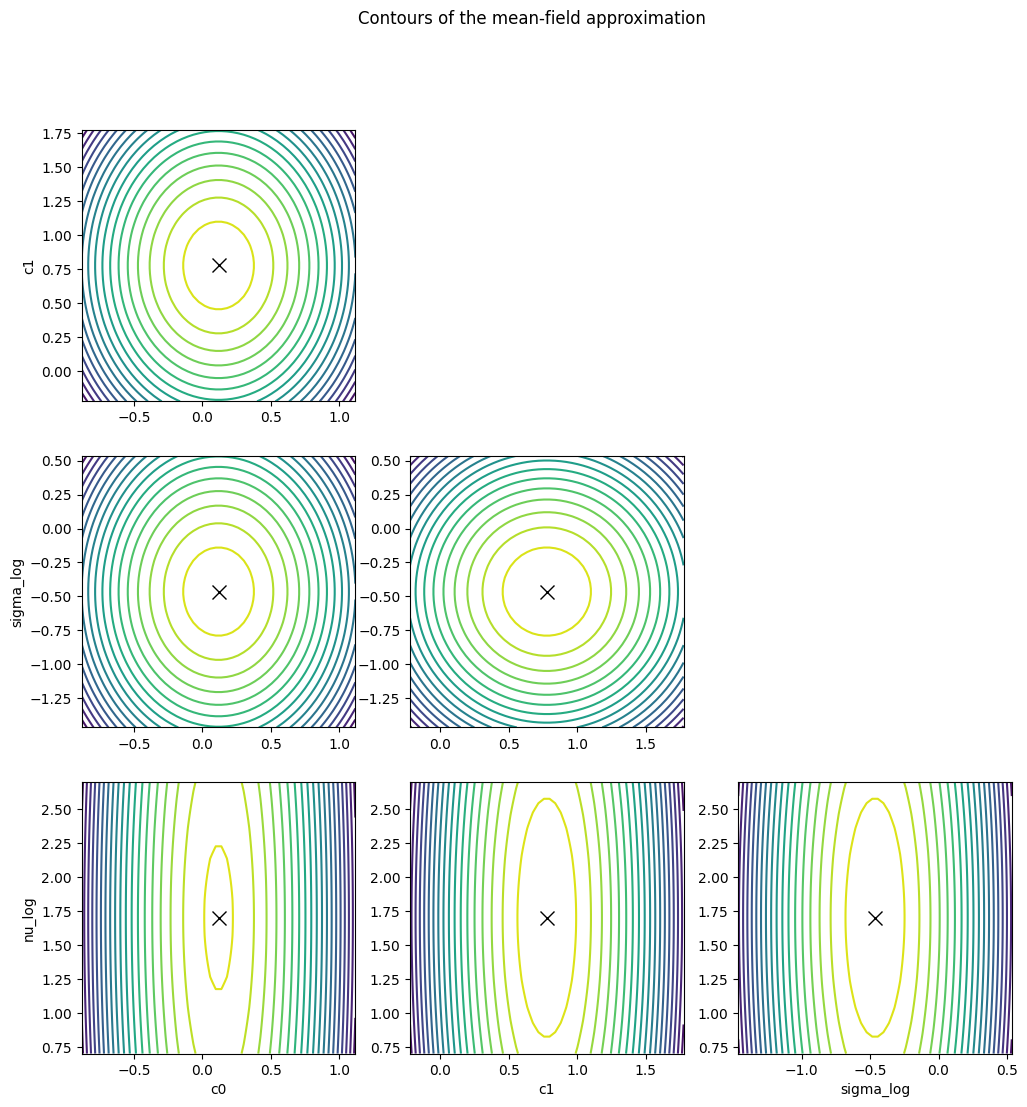

In [11]:
# Create the mean-field Multivariate Normal model. The mean-field precision
# is just the diagonal of the full-rank precision.
precision_mean_field = np.diag(np.diag(precision))
with pm.Model() as approx_mean_field:

    # The Multivariate Normal approximation
    x = pm.MvNormal('x', mu=result.x, tau=precision_mean_field)

    # Map from the x vector to the parameters of the original model.
    c_0 = pm.Deterministic('c0', x[0])
    c_1 = pm.Deterministic('c1', x[1])
    sigma = pm.Deterministic('sigma', pm.math.exp(x[2]))
    nu = pm.Deterministic('nu', pm.math.exp(x[3]))

# Make the plots
plt.figure(figsize=(12, 12))
plt.suptitle('Contours of the mean-field approximation')
for i in range(len(var_names)-1):
    for j in range(i + 1):
        plt.subplot(len(var_names)-1, len(var_names)-1, i * (len(var_names)-1) + j + 1)
        var_x = var_names[j]
        var_y = var_names[i + 1]
        plot_two_parameter_log_posterior_contour(
            approx_mean_field,
            (
                (f'x[{j}]', np.linspace(x_opt[var_x] - 1, x_opt[var_x] + 1)),
                (f'x[{i+1}]', np.linspace(x_opt[var_y] - 1, x_opt[var_y] + 1))),
            {'x': np.array([x_opt[var_names[k]] for k in range(len(x_opt))])},
            contour_kwargs={'levels': 20})
        plt.plot([x_opt[var_x]], [x_opt[var_y]], 'kx', markersize=10)
        if j == 0:
            plt.ylabel(var_y.rstrip('_'))
        if i == len(var_names) - 2:
            plt.xlabel(var_x.rstrip('_'))
plt.show()

Compare these contour plots to those of the original model. Write a short paragraph explaining what you think is good and what is bad about the approximation.

In [12]:
# ENTER YOUR ANSWER IN FORUM

## Comparison

Let's compare the posteriors over the variables by sampling from the original model and the full-rank and mean-field approximations. Your task is to analyze the results in detail and identify what discrepancies there are between the original and the approximations.

Record your observations here.

In [13]:
# ENTER YOUR ANSWER IN FORUM

### Original model

Output()

ERROR:pymc.stats.convergence:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
c0      0.083   0.120  -0.147    0.295      0.004    0.002     994.0   
c1      0.716   0.138   0.455    0.957      0.004    0.003    1316.0   
nu     14.855  14.855   1.300   44.046      0.447    0.473     835.0   
sigma   0.698   0.119   0.449    0.895      0.004    0.003     830.0   

       ess_tail  r_hat  
c0       1056.0    1.0  
c1       1141.0    1.0  
nu        799.0    1.0  
sigma     701.0    1.0

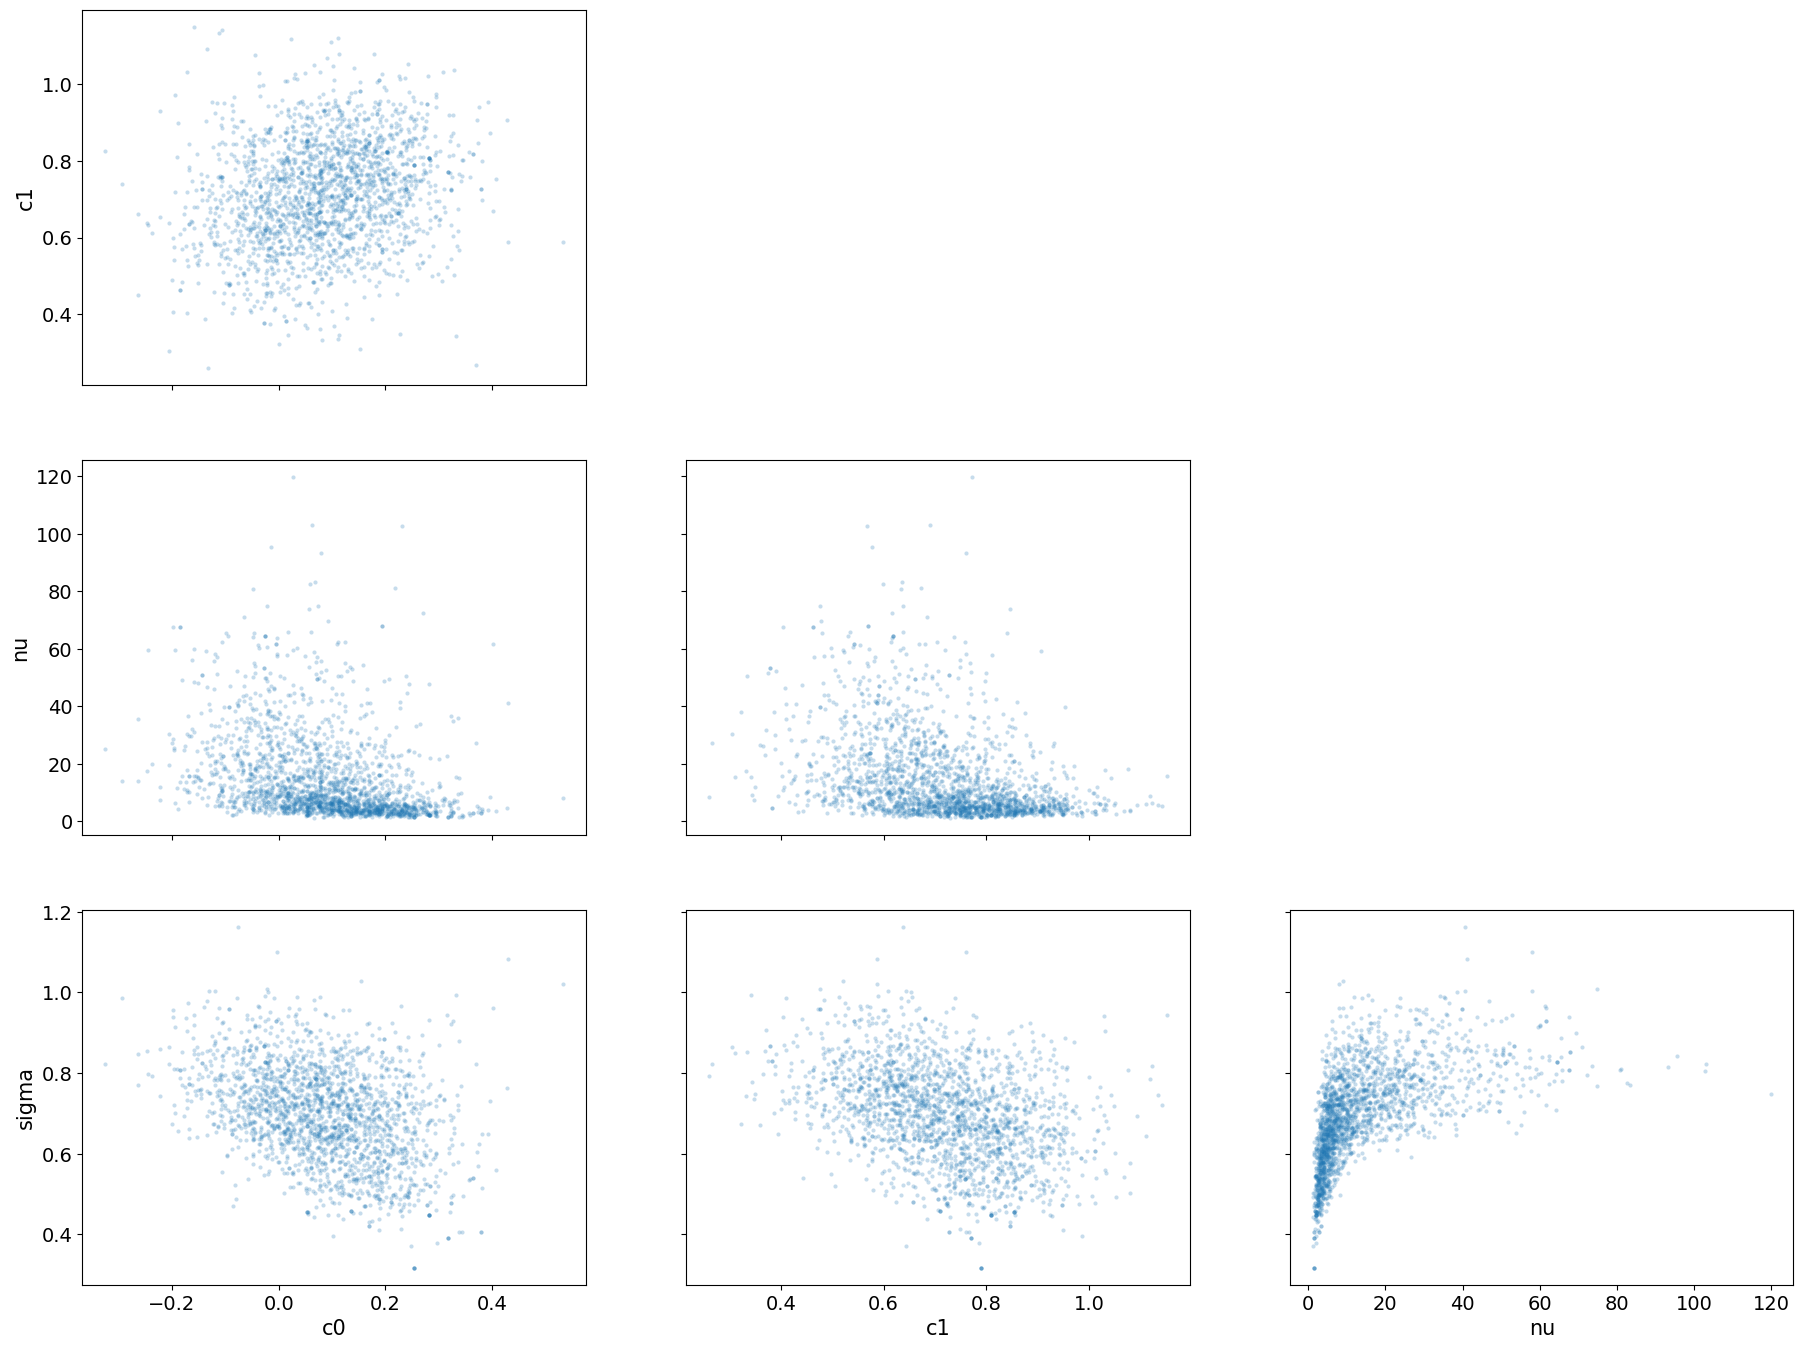

In [14]:
with model:
    inference = pm.sample()

az.plot_pair(inference, var_names=['~mu'], scatter_kwargs={'alpha': 0.25})

display(az.summary(inference, var_names=['~mu']))

### Full-rank approximation

**Note:** We visualize the results over the reverse-transformed variables so the plots won't look like Normals. There are non-linear transformations from $\log\sigma$ to $\sigma$ and from $\log\nu$ to $\nu$.

mean     sd  hdi_3%  hdi_97%
c0     0.116  0.118  -0.102    0.342
c1     0.778  0.132   0.540    1.028
sigma  0.647  0.134   0.411    0.900
nu     8.243  9.312   0.240   21.952

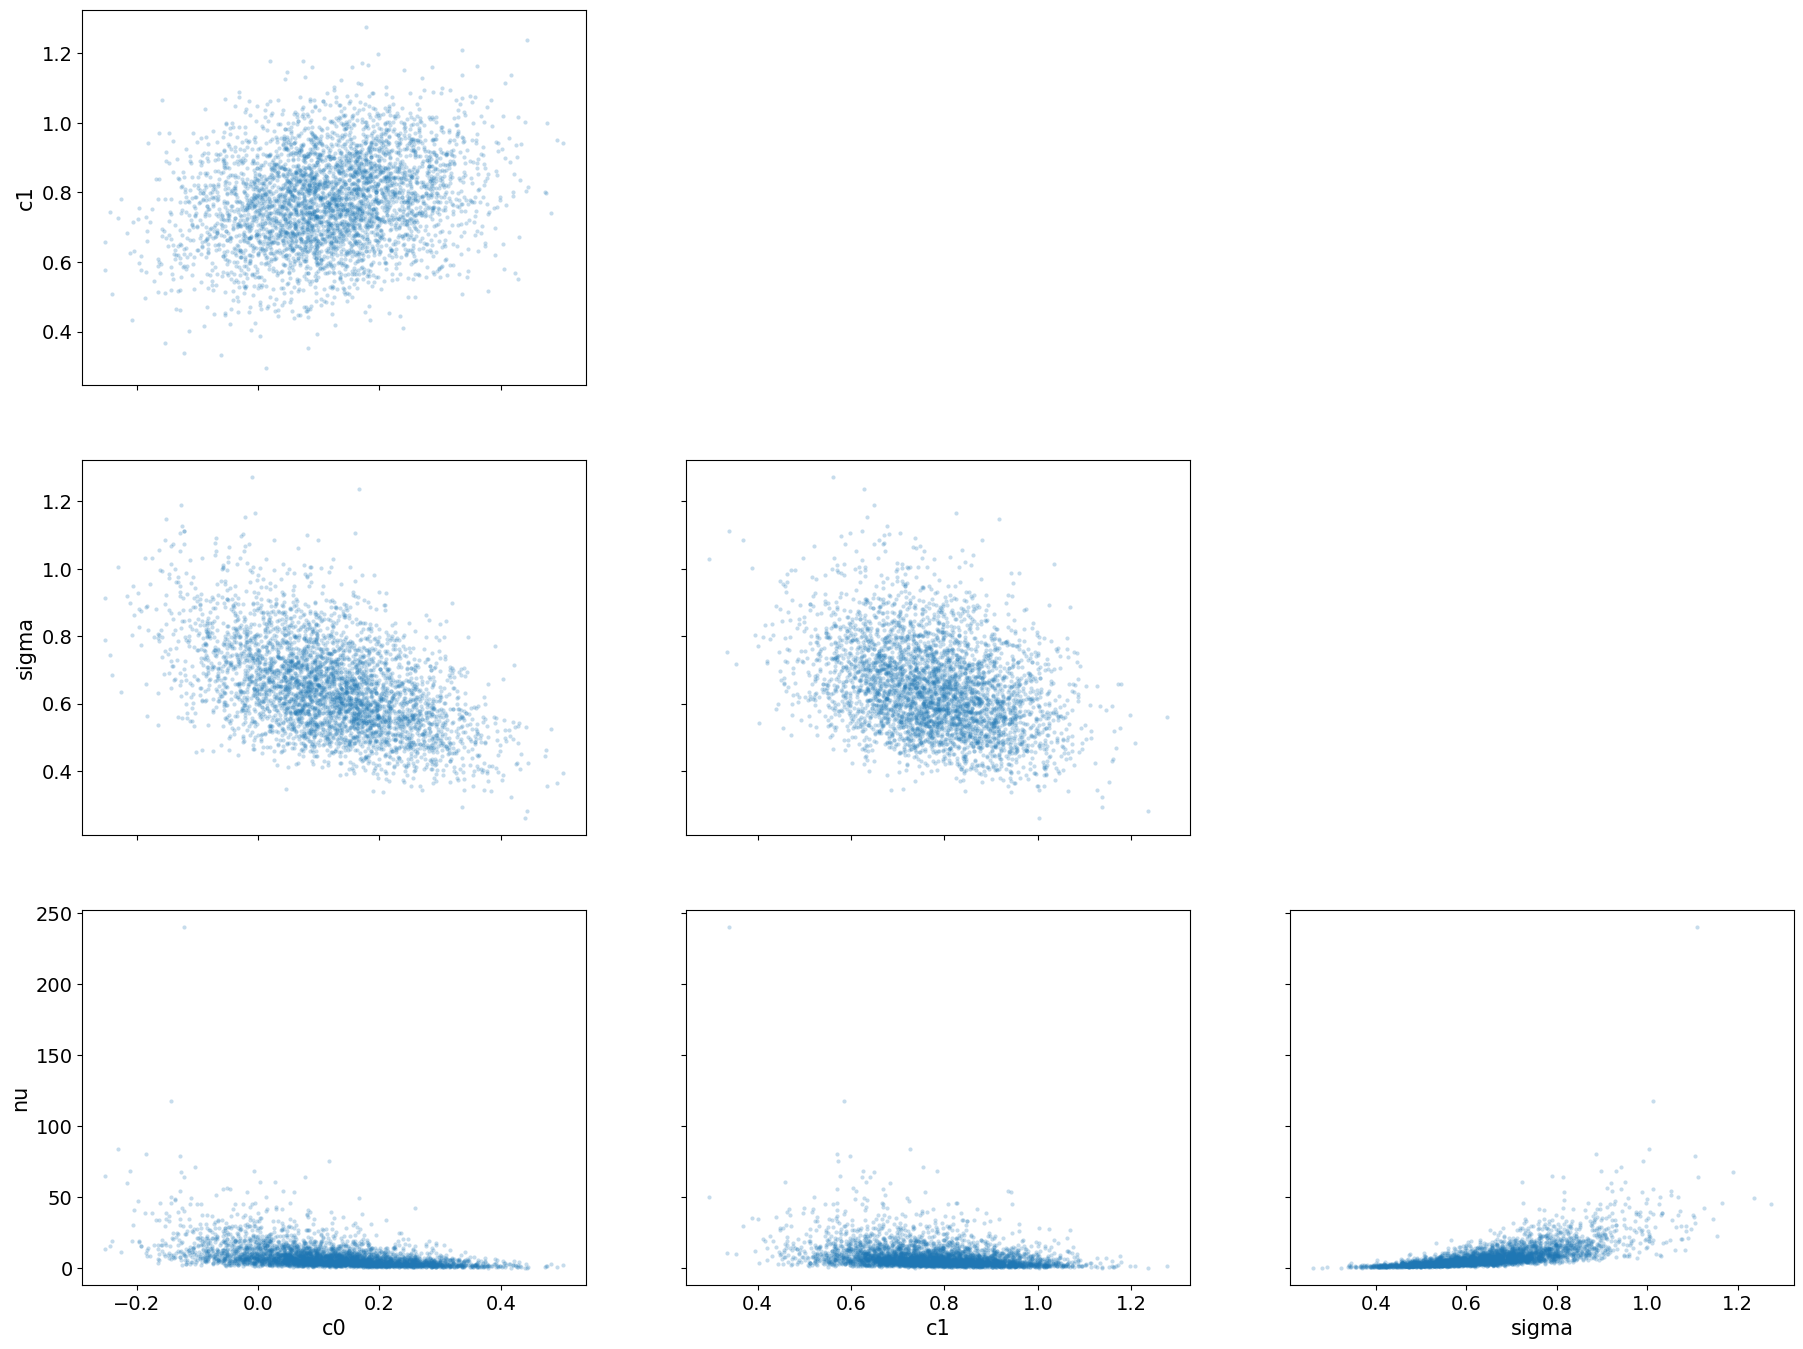

In [15]:
# Here we sample from the prior since the approximations don't have
# observed data. We just defined a Normal distribution over the
# variables directly.
with approx_full_rank:
    samples = pm.sample_prior_predictive(4000)

az.plot_pair(
    samples, var_names=['c0', 'c1', 'sigma', 'nu'],
    group='prior', scatter_kwargs={'alpha': 0.25})

display(az.summary(
    samples, var_names=['c0', 'c1', 'sigma', 'nu'],
    group='prior', kind='stats'))

### Mean-field approximation

mean     sd  hdi_3%  hdi_97%
c0     0.120  0.097  -0.063    0.301
c1     0.774  0.122   0.555    1.007
sigma  0.635  0.076   0.500    0.782
nu     6.202  3.254   1.515   12.208

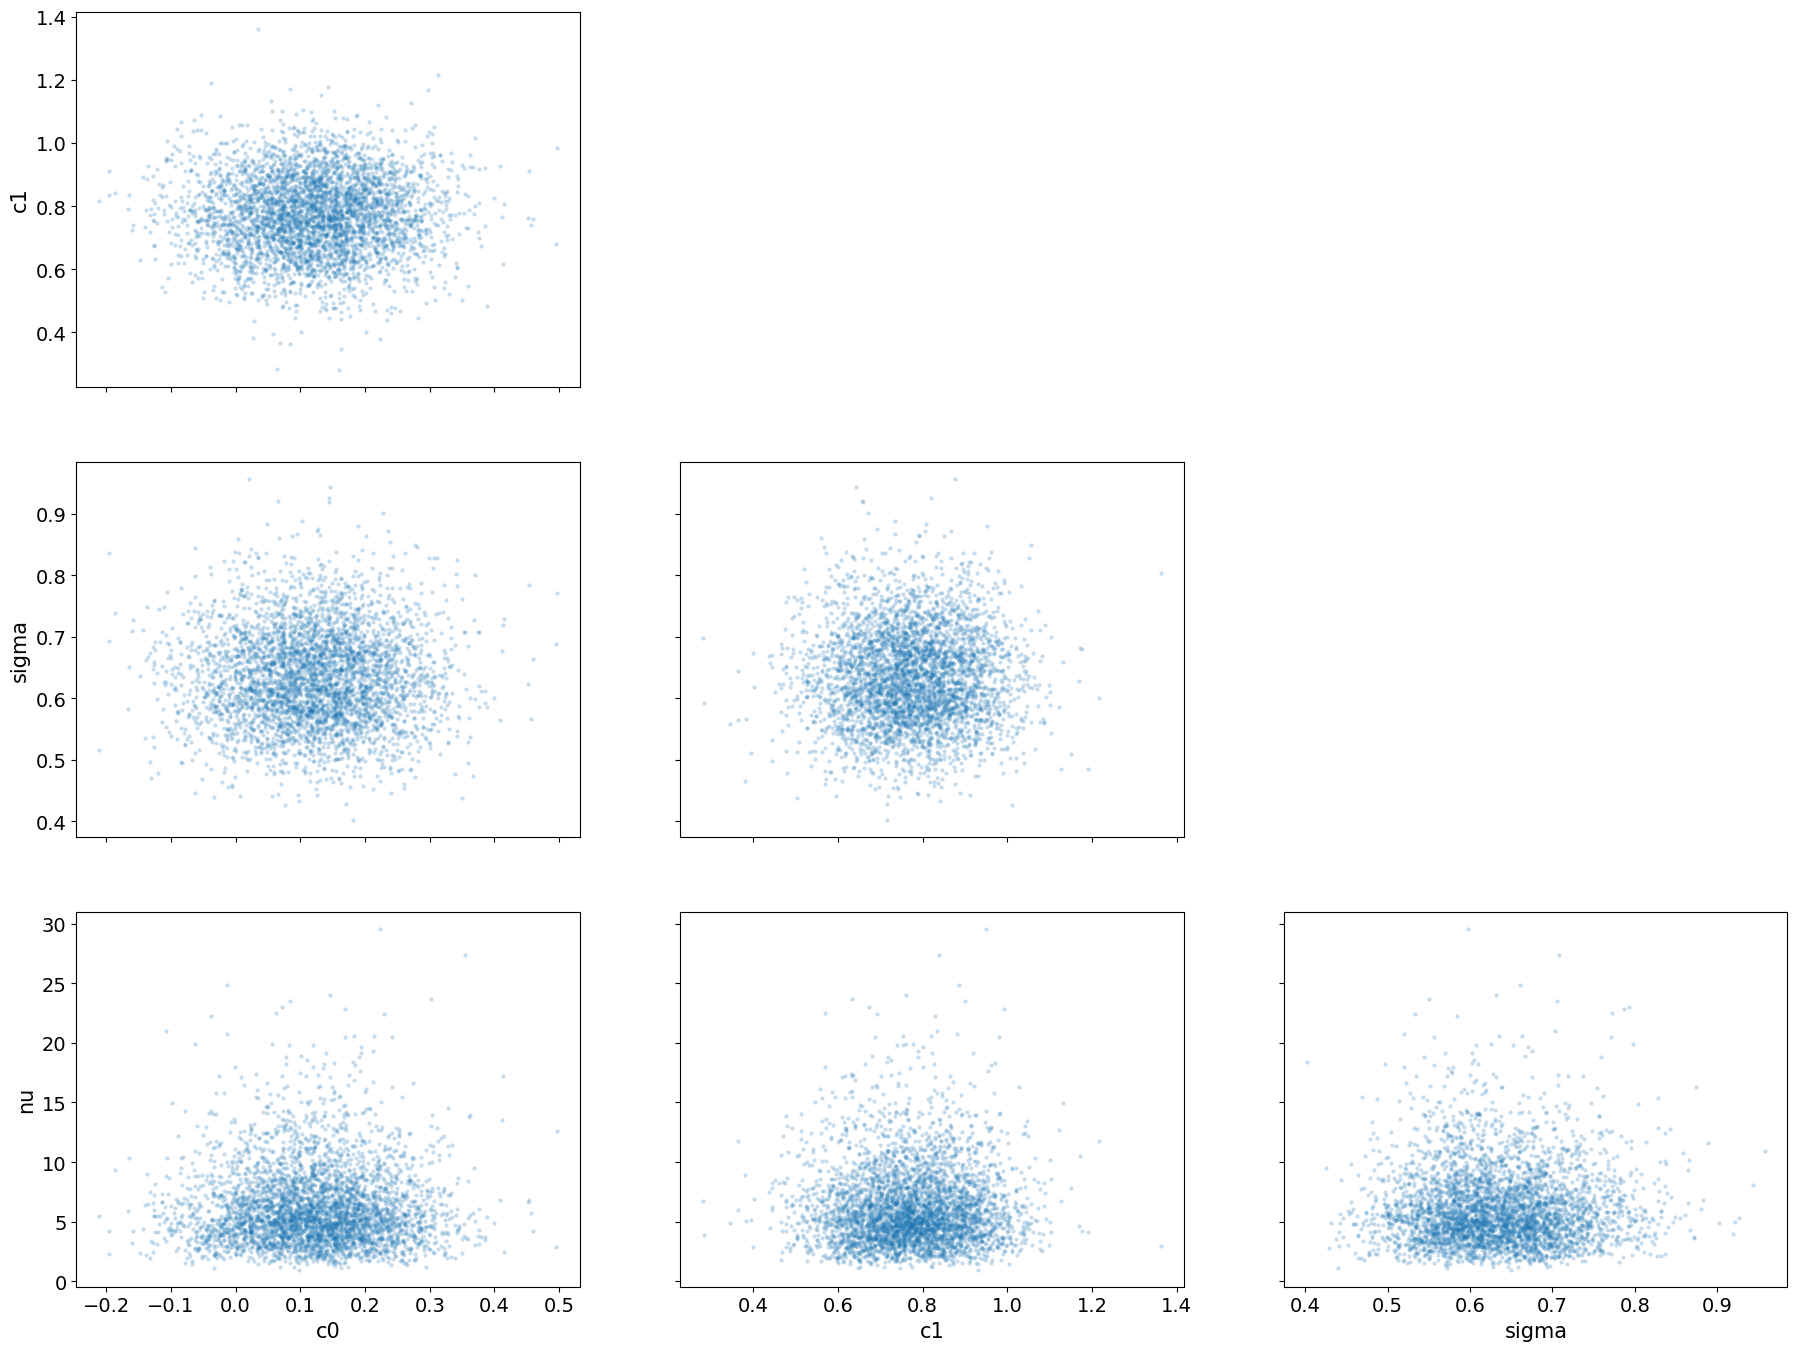

In [16]:
with approx_mean_field:
    samples = pm.sample_prior_predictive(4000)

az.plot_pair(
    samples, var_names=['c0', 'c1', 'sigma', 'nu'],
    group='prior', scatter_kwargs={'alpha': 0.25})

display(az.summary(
    samples, var_names=['c0', 'c1', 'sigma', 'nu'],
    group='prior', kind='stats'))

## Task: Fit another distribution

Below is a model we discussed briefly in a previous class. The data follow a linear trend with a periodic variation on top of that and measurement noise. The likelihood is

$$y \sim \text{Normal}(c_0 + c_1 x + \alpha\cos\left(2\pi x+\phi\right), \sigma^2)$$

The PyMC code for the model is provided below. Your task is to compute the full-rank and mean-field approximations to this model by reusing the code above.

You should also analyze how good the approximations are.

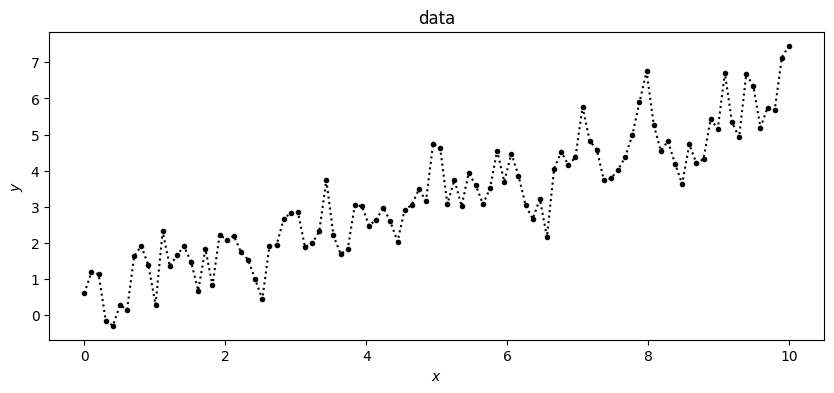

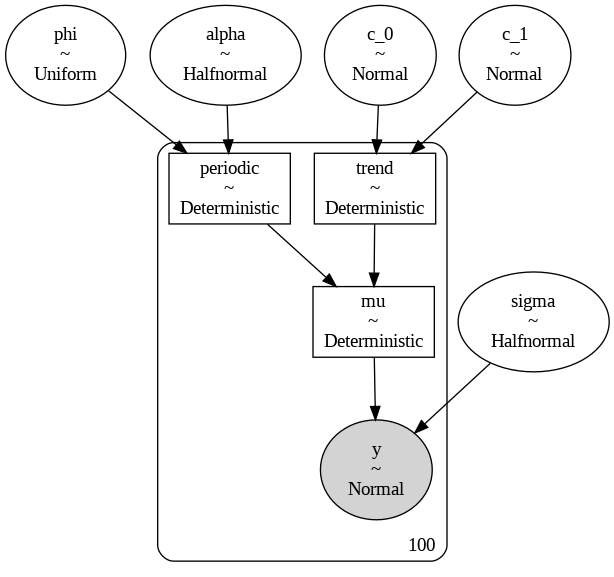

In [22]:
data_x = np.linspace(0, 10, 100)
data_y = [
    0.608, 1.201, 1.136, -0.150, -0.291, 0.279, 0.156, 1.637, 1.914, 1.378,
    0.291, 2.324, 1.354, 1.659, 1.913, 1.471, 0.681, 1.835, 0.823, 2.226,
    2.089, 2.199, 1.749, 1.538, 0.994, 0.436, 1.918, 1.938, 2.663, 2.833,
    2.860, 1.890, 1.986, 2.319, 3.734, 2.208, 1.699, 1.826, 3.045, 3.022,
    2.480, 2.642, 2.978, 2.596, 2.036, 2.919, 3.054, 3.483, 3.169, 4.747,
    4.618, 3.082, 3.745, 3.020, 3.926, 3.605, 3.071, 3.510, 4.554, 3.698,
    4.473, 3.864, 3.043, 2.666, 3.218, 2.164, 4.050, 4.528, 4.161, 4.371,
    5.766, 4.827, 4.585, 3.734, 3.788, 4.027, 4.386, 4.988, 5.896, 6.754,
    5.272, 4.555, 4.819, 4.197, 3.628, 4.728, 4.207, 4.322, 5.433, 5.158,
    6.705, 5.344, 4.927, 6.672, 6.348, 5.195, 5.749, 5.674, 7.128, 7.461]

# Plot the data
plt.figure(figsize=(10, 4))
plt.title('data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(data_x, data_y, 'k.:');
plt.show()

with pm.Model() as model:

    # Trend line parameters
    c_0 = pm.Normal('c_0', mu=0, sigma=1)  # Intercept
    c_1 = pm.Normal('c_1', mu=0, sigma=1)  # Slope

    # Periodic function parameters
    alpha = pm.HalfNormal('alpha', sigma=1)       # Amplitude
    phi = pm.Uniform('phi', lower=-np.pi, upper=np.pi)  # Phase

    # Measurement noise parameter
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Deterministic mappings to create the mean of the measurements
    trend = pm.Deterministic('trend', c_0 + c_1 * data_x)
    periodic = pm.Deterministic('periodic', alpha * pm.math.cos(2*np.pi*data_x + phi))
    mu = pm.Deterministic('mu', trend + periodic)

    # Likelihood, which is a noisy measurement around the mean mu
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data_y)

# Draw the graphical model
from IPython.display import Image
Image(pm.model_to_graphviz(model).render(format='png'))

In [18]:
# YOUR WORK GOES HERE; PASTE YOUR CODE INTO THE FORUM WORKBOOK

Compare the marginal distributions over the variables between the full-rank and mean-field approximations. What do you observe?

['c_0', 'c_1', 'alpha_log__', 'phi_interval__', 'sigma_log__']
x-coordinate at peak:             [ 0.54019649  0.54069707 -0.58298872  0.02153519 -0.47501795]
derivative at peak (should be 0): [ 1.99367146e-08  1.64939807e-07  1.47015558e-08 -8.29162028e-09
 -2.03939774e-08]
log posterior value at peak:      -99.46055372502528


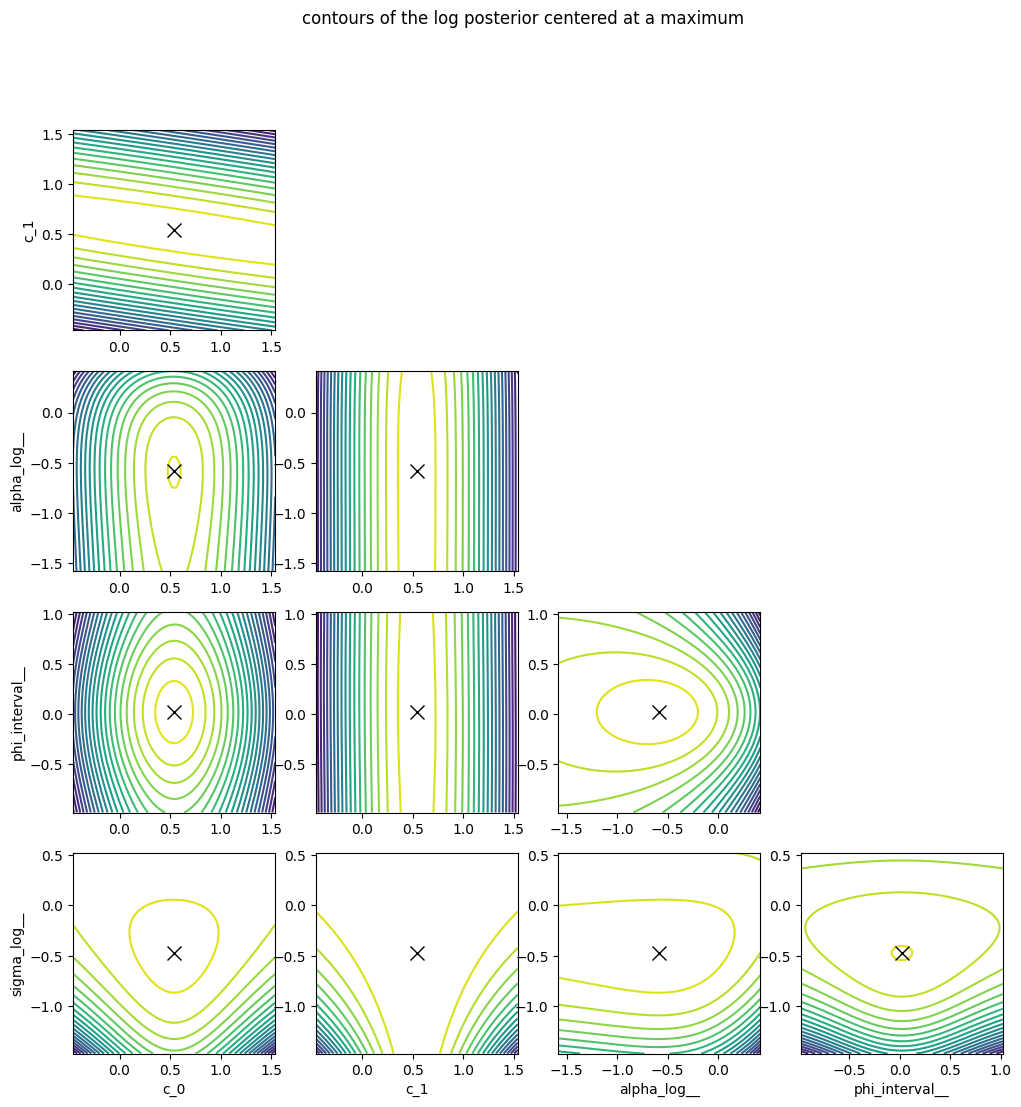

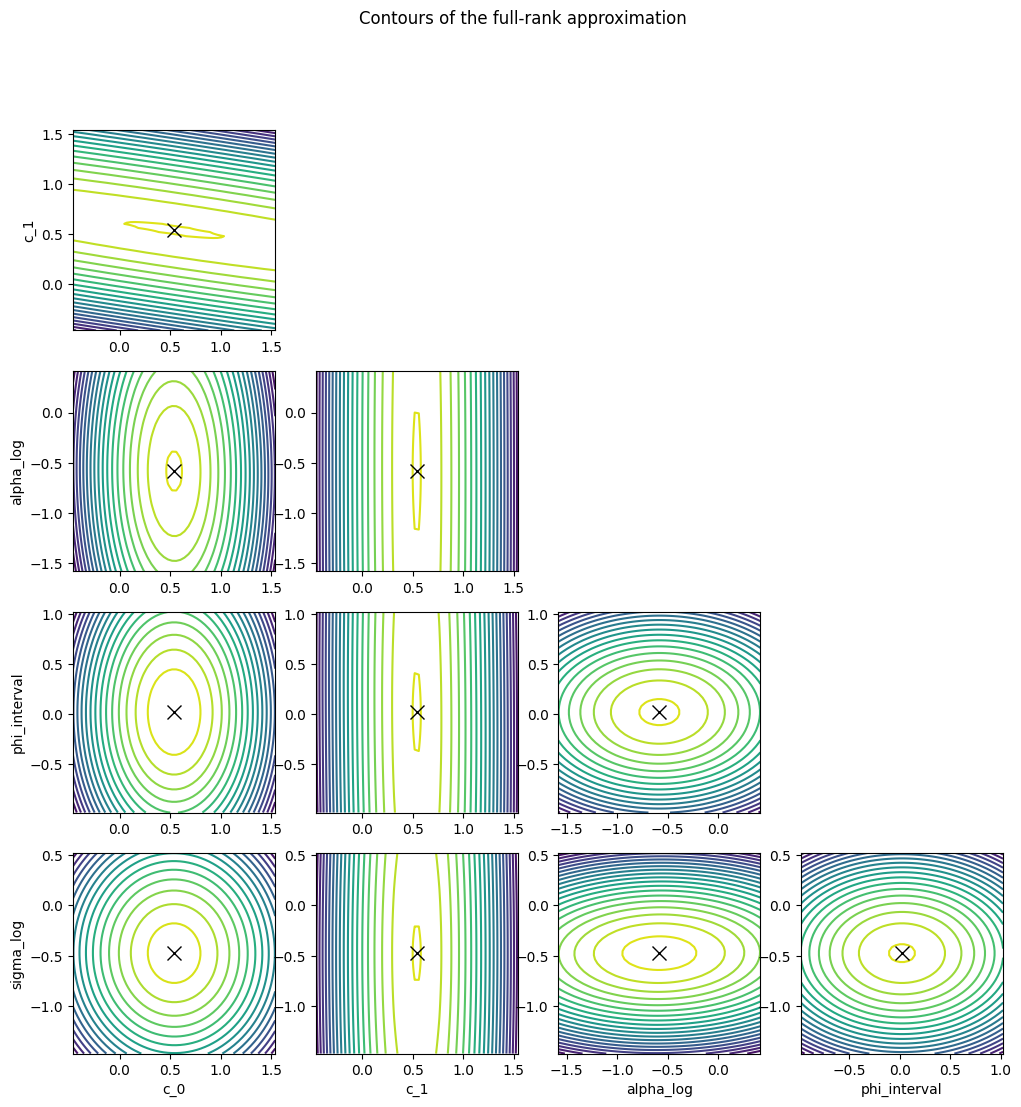

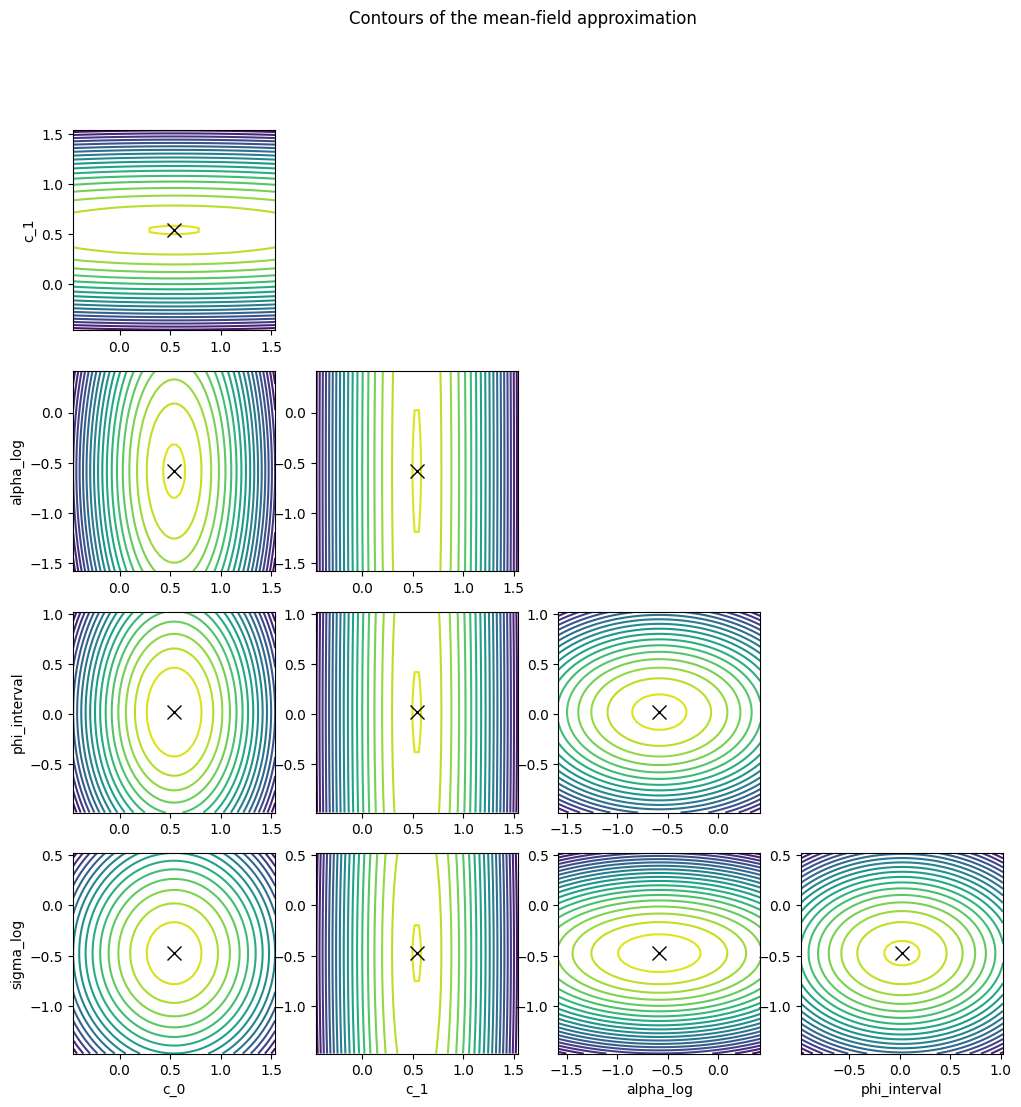

In [32]:
# FULL RANK MODEL

# first find the optimal points

# update the variable names
var_names = [x.name for x in model.value_vars]
print(var_names)

logp = model.compile_logp()  # log posterior (unnormalized)
dlogp = model.compile_dlogp()  # derivative of the unnormalized log posterior

# The two functions below map from a NumPy array with 4 values
# to the 4 unconstrained variables of the model. These functions
# also invert the sign of the function so we can use `minimize`
# to find the maximum of the log posterior.

def f(x):
    # The function to minimize
    return -logp(dict(zip(var_names, x)))

def df(x):
    # Derivative of the function to minimize
    return -dlogp(dict(zip(var_names, x)))

# finding the values for which the log posterior is minimized
result = minimize(f, np.zeros(5), jac=df)
x_opt = {name: result.x[i] for i, name in enumerate(var_names)}  # x-coordinate of optimum
f_opt = -result.fun  # function value at optimum

# printing out the results
print('x-coordinate at peak:            ', result.x)
print('derivative at peak (should be 0):', result.jac)
print('log posterior value at peak:     ', -result.fun)

# making the contour plot for the original data (using the plotting code above)
plt.figure(figsize=(12, 12))
plt.suptitle('contours of the log posterior centered at a maximum')
for i in range(len(var_names)-1):
    for j in range(i + 1):
        plt.subplot(len(var_names)-1, len(var_names)-1, i * (len(var_names)-1) + j + 1)
        var_x = var_names[j]
        var_y = var_names[i + 1]
        plot_two_parameter_log_posterior_contour(
            model,
            (
                (var_x, np.linspace(x_opt[var_x] - 1, x_opt[var_x] + 1)),
                (var_y, np.linspace(x_opt[var_y] - 1, x_opt[var_y] + 1))),
            x_opt,
            contour_kwargs={'levels': 20})
        plt.plot([x_opt[var_x]], [x_opt[var_y]], 'kx', markersize=10)
        if j == 0:
            plt.ylabel(var_y)
        if i == len(var_names) - 2:
            plt.xlabel(var_x)
plt.show()

# FULl-RANK MODEL
d2logp = model.compile_d2logp(negate_output=False)
precision = -d2logp(x_opt)

# Create the full-rank Multivariate Normal model
with pm.Model() as approx_full_rank:

    # The Multivariate Normal approximation
    x = pm.MvNormal('x', mu=result.x, tau=precision)

    # Map from the x vector to the parameters of the original model.
    c_0 = pm.Deterministic('c0', x[0])
    c_1 = pm.Deterministic('c1', x[1])
    alpha = pm.Deterministic('alpha', x[2])
    phi = pm.Deterministic('phi', pm.math.exp(x[3]))
    sigma = pm.Deterministic('sigma', pm.math.exp(x[4]))

plt.figure(figsize=(12, 12))
plt.suptitle('Contours of the full-rank approximation')
for i in range(len(var_names)-1):
    for j in range(i + 1):
        plt.subplot(len(var_names)-1, len(var_names)-1, i * (len(var_names)-1) + j + 1)
        var_x = var_names[j]
        var_y = var_names[i + 1]
        plot_two_parameter_log_posterior_contour(
            approx_full_rank,
            (
                (f'x[{j}]', np.linspace(x_opt[var_x] - 1, x_opt[var_x] + 1)),
                (f'x[{i+1}]', np.linspace(x_opt[var_y] - 1, x_opt[var_y] + 1))),
            {'x': np.array([x_opt[var_names[k]] for k in range(len(x_opt))])},
            contour_kwargs={'levels': 20})
        plt.plot([x_opt[var_x]], [x_opt[var_y]], 'kx', markersize=10)
        if j == 0:
            plt.ylabel(var_y.rstrip('_'))
        if i == len(var_names) - 2:
            plt.xlabel(var_x.rstrip('_'))
plt.show()


# MEAN FIELD APPROXIMATION
# Create the mean-field Multivariate Normal model. The mean-field precision
# is just the diagonal of the full-rank precision.
precision_mean_field = np.diag(np.diag(precision))
with pm.Model() as approx_mean_field:

    # The Multivariate Normal approximation
    x = pm.MvNormal('x', mu=result.x, tau=precision_mean_field)

    # Map from the x vector to the parameters of the original model.
    c_0 = pm.Deterministic('c0', x[0])
    c_1 = pm.Deterministic('c1', x[1])
    alpha = pm.Deterministic('alpha', x[2])
    phi = pm.Deterministic('phi', pm.math.exp(x[3]))
    sigma = pm.Deterministic('sigma', pm.math.exp(x[4]))

# Make the plots
plt.figure(figsize=(12, 12))
plt.suptitle('Contours of the mean-field approximation')
for i in range(len(var_names)-1):
    for j in range(i + 1):
        plt.subplot(len(var_names)-1, len(var_names)-1, i * (len(var_names)-1) + j + 1)
        var_x = var_names[j]
        var_y = var_names[i + 1]
        plot_two_parameter_log_posterior_contour(
            approx_mean_field,
            (
                (f'x[{j}]', np.linspace(x_opt[var_x] - 1, x_opt[var_x] + 1)),
                (f'x[{i+1}]', np.linspace(x_opt[var_y] - 1, x_opt[var_y] + 1))),
            {'x': np.array([x_opt[var_names[k]] for k in range(len(x_opt))])},
            contour_kwargs={'levels': 20})
        plt.plot([x_opt[var_x]], [x_opt[var_y]], 'kx', markersize=10)
        if j == 0:
            plt.ylabel(var_y.rstrip('_'))
        if i == len(var_names) - 2:
            plt.xlabel(var_x.rstrip('_'))
plt.show()

## (Optional) What is ADVI?

You just learned how we can approximate a target distribution by finding its peak and matching the second-order derivatives of a Normal PDF to the second-order derivatives of the target at the peak. A big drawback of this approach is that it captures the behavior of the target at the peak only. If the second-order derivatives change away from the peak, for example, the Normal will be a poor fit away from the peak. (The second-order derivatives of the Normal are constant.)

The algorithm implemented in PyMC, Automatic Differentiation Variational Inference, fits a Normal (full-rank or mean-field) to the target by minimizing the KL-divergence between the distributions instead. This is significantly more complicated mathematically and computationally but the result is a better fit to the target distribution.

**This part of the pre-class work is optional.** You are not expected to understand how ADVI works in this course. It is the sort of thing you might be expected to understand in detail if you go to grad school. For those who are interested, an outline of the algorithm is provided below.

The ADVI algorithm aims to minimize $\text{KL}(q\,||\,p)$ where $q$ is the approximating distribution and $p$ is the target distribution by following these steps.

1. Instead of minimizing $\text{KL}(q\,||\,p)$, we maximize something called the _evidence lower bound_ (ELBO), $E_q(\log p(\text{data}, \theta)) - E_q(\log q)$. ([You can find a derivation here](https://mpatacchiola.github.io/blog/2021/01/25/intro-variational-inference.html), showing that these two optimization problems are equivalent).

2. We choose the approximating distribution, $q$, such that we know its entropy $E_q(\log q)$ and it is easy to generate samples from $q$. Any of the standard distributions we learned about satisfy these requirements. The Normal is the traditional choice since it is easy to work with Multivariate Normals in any dimension.

3. Computing $E_q(\log p(\text{data}, \theta))$ is still hard — it is sometimes possible but that depends on the form of the unnormalized log posterior $\log p$). Instead, we approximate this expectation using sampling. We sample from $q$ which is easy by design and we average over the values of $\log p$ evaluated the samples, which is also straightforward since we know the unnormalized log posterior.

4. Finally, ADVI uses a stochastic (random sample-based) gradient-ascent algorithm to maximize the ELBO. Stochastic optimization algorithms deserve a course of their own. PyMC uses the [_Adam_ algorithm](https://arxiv.org/abs/1412.6980) for this part.

If you would like to learn more, [here is a nice video](https://www.youtube.com/watch?v=_iNajZR6jY4) to help understand mean-field variational inference. if you want all the messy details, [the original ADVI paper](https://arxiv.org/abs/1603.00788) is surprisingly readable given how technical this material generally is.